# Modélisation et évaluation des modèles

**Auteur :** Mehdi MUNIM

**Date :** 2023-11-26

**Description :**

Ce notebook entraîne et évalue différents modèles de Machine Learning pour la classification de sentiment sur les données de tweets prétraitées.

In [1]:
#@title 1. Importation des librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import tensorflow as tf 

# Ajouter le chemin du dossier src pour importer les modules
sys.path.append('../src')
import model
import evaluation

2024-12-02 20:23:10.845648: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Chargement des données

In [2]:
#@title 2.1 Chargement des données

# Chemin d'accès au dossier data
data_path = '../data/processed/'

# Charger les données prétraitées
X_train = pickle.load(open(data_path + 'X_train.pickle', 'rb'))
X_test = pickle.load(open(data_path + 'X_test.pickle', 'rb'))
X_train_tfidf = pickle.load(open(data_path + 'X_train_tfidf.pickle', 'rb'))
X_test_tfidf = pickle.load(open(data_path + 'X_test_tfidf.pickle', 'rb'))
X_train_w2v = pickle.load(open(data_path + 'X_train_word2vec.pickle', 'rb'))
X_test_w2v = pickle.load(open(data_path + 'X_test_word2vec.pickle', 'rb'))
X_train_d2v = pickle.load(open(data_path + 'X_train_doc2vec.pickle', 'rb'))
X_test_d2v = pickle.load(open(data_path + 'X_test_doc2vec.pickle', 'rb'))
y_train = pickle.load(open(data_path + 'y_train.pickle', 'rb'))
y_test = pickle.load(open(data_path + 'y_test.pickle', 'rb'))

## 3. Entraînement et évaluation des modèles

Accuracy: 0.7475
Precision: 0.7297
Recall: 0.7662
F1-score: 0.7475


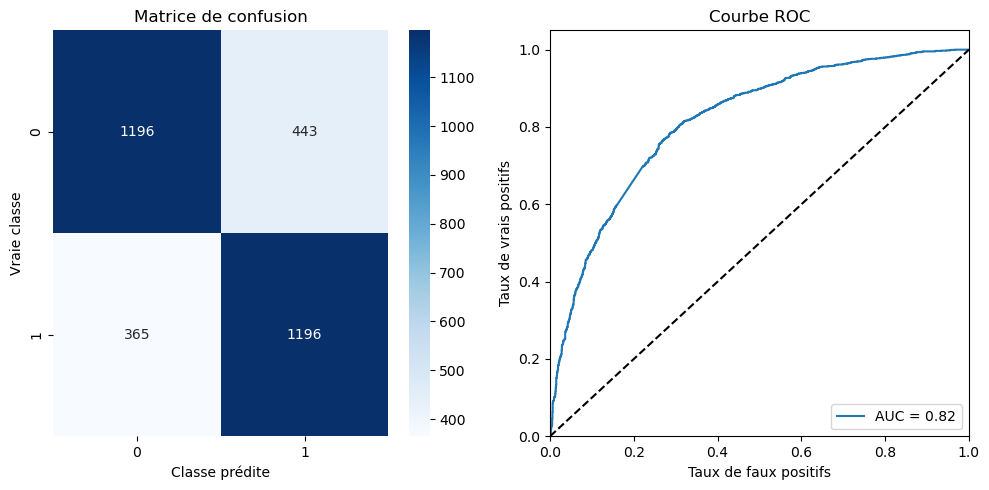

In [3]:
#@title 3.1 Entraînement et évaluation du modèle de régression logistique

from sklearn.linear_model import LogisticRegression

# Créer et entraîner le modèle de régression logistique
model_lr = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42)
model_lr.fit(X_train_tfidf, y_train)

# Évaluer le modèle
evaluation.evaluer_modele(model_lr, X_test_tfidf, y_test)

# Sauvegarder le modèle avec pickle
with open('../models/mon_modele_lr.pkl', 'wb') as f:
    pickle.dump(model_lr, f)

Epoch 1/10
320/320 [==============================] - 2s 3ms/step - loss: 0.6950 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4957
Epoch 2/10
320/320 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.4990 - val_loss: 0.6927 - val_accuracy: 0.5199
Epoch 3/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5011 - val_loss: 0.6926 - val_accuracy: 0.5266
Epoch 4/10
320/320 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5100 - val_loss: 0.6926 - val_accuracy: 0.5145
Epoch 5/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5097 - val_loss: 0.6926 - val_accuracy: 0.5160
Epoch 6/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5063 - val_loss: 0.6926 - val_accuracy: 0.5066
Epoch 7/10
320/320 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5015 - val_loss: 0.6926 - val_accuracy: 0.5137
Epoch 

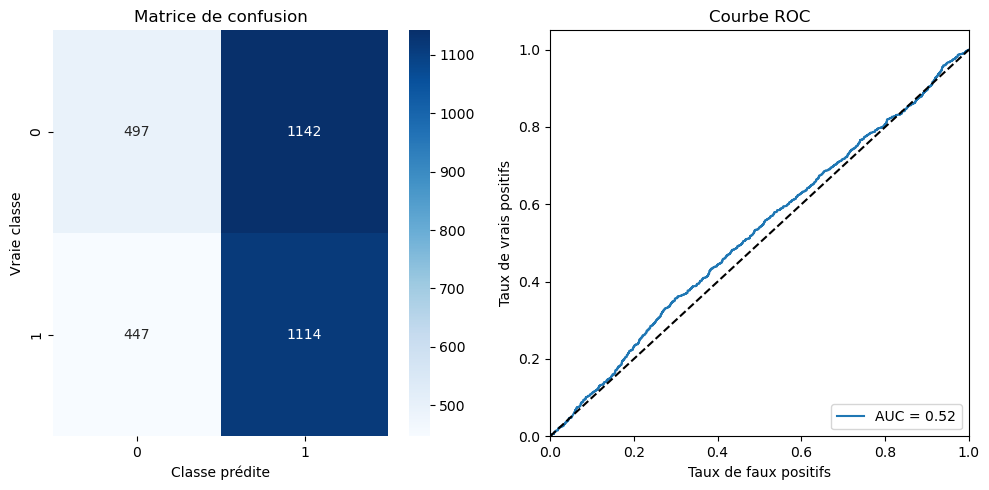

In [4]:
#@title 3.2 Entraînement et évaluation du modèle MLP

# Créer et entraîner le modèle MLP
model_mlp = model.create_mlp_model(input_shape=(X_train_w2v.shape[1],))
model_mlp.fit(X_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_mlp, X_test_w2v, y_test)

# Sauvegarder le modèle
model.save_model_weights(model_mlp, "model_mlp")

Epoch 1/10
320/320 [==============================] - 4s 9ms/step - loss: 0.6936 - accuracy: 0.5015 - val_loss: 0.6929 - val_accuracy: 0.5168
Epoch 2/10
320/320 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.5120 - val_loss: 0.6928 - val_accuracy: 0.5113
Epoch 3/10
320/320 [==============================] - 2s 7ms/step - loss: 0.6929 - accuracy: 0.5067 - val_loss: 0.6923 - val_accuracy: 0.5188
Epoch 4/10
320/320 [==============================] - 3s 10ms/step - loss: 0.6930 - accuracy: 0.5099 - val_loss: 0.6926 - val_accuracy: 0.5215
Epoch 5/10
320/320 [==============================] - 5s 15ms/step - loss: 0.6930 - accuracy: 0.5104 - val_loss: 0.6923 - val_accuracy: 0.5273
Epoch 6/10
320/320 [==============================] - 5s 14ms/step - loss: 0.6928 - accuracy: 0.5115 - val_loss: 0.6925 - val_accuracy: 0.5207
Epoch 7/10
320/320 [==============================] - 5s 16ms/step - loss: 0.6930 - accuracy: 0.5120 - val_loss: 0.6925 - val_accuracy: 0.5125
Ep

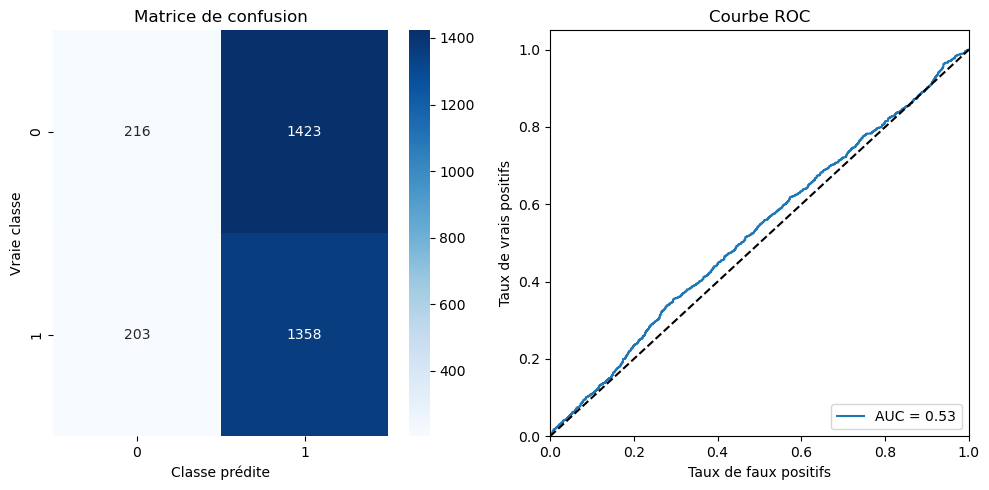

In [5]:
#@title 3.3 Entraînement et évaluation du modèle CNN

# Reshape les données pour le modèle CNN
X_train_cnn = np.reshape(X_train_w2v, (X_train_w2v.shape[0], X_train_w2v.shape[1], 1))
X_test_cnn = np.reshape(X_test_w2v, (X_test_w2v.shape[0], X_test_w2v.shape[1], 1))

# Créer et entraîner le modèle CNN
model_cnn = model.create_cnn_model(input_shape=(X_train_cnn.shape[1], 1))
model_cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_cnn, X_test_cnn, y_test)

# Sauvegarder le modèle
model.save_model_weights(model_cnn, "model_cnn")

Epoch 1/10
320/320 [==============================] - 4s 7ms/step - loss: 0.6942 - accuracy: 0.4951 - val_loss: 0.6925 - val_accuracy: 0.5195
Epoch 2/10
320/320 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.5057 - val_loss: 0.6923 - val_accuracy: 0.5203
Epoch 3/10
320/320 [==============================] - 2s 7ms/step - loss: 0.6930 - accuracy: 0.5093 - val_loss: 0.6927 - val_accuracy: 0.4941
Epoch 4/10
320/320 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6921 - val_accuracy: 0.5285
Epoch 5/10
320/320 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.5153 - val_loss: 0.6932 - val_accuracy: 0.5168
Epoch 6/10
320/320 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.5105 - val_loss: 0.6919 - val_accuracy: 0.5320
Epoch 7/10
320/320 [==============================] - 2s 6ms/step - loss: 0.6927 - accuracy: 0.5124 - val_loss: 0.6920 - val_accuracy: 0.5199
Epoch 

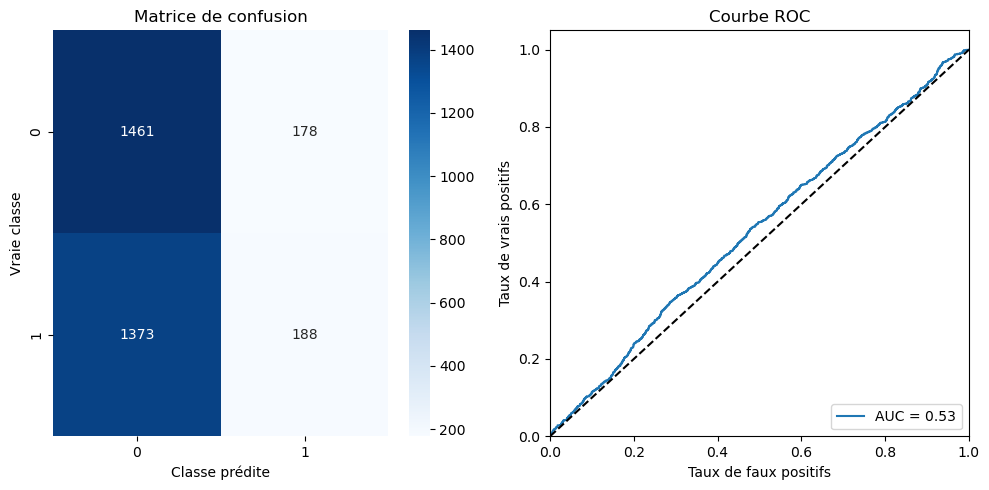

In [6]:
#@title 3.4 Entraînement et évaluation du modèle LSTM

# Créer et entraîner le modèle LSTM
model_lstm = model.create_lstm_model(input_shape=(X_train_w2v.shape[1],))
model_lstm.fit(X_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_lstm, X_test_w2v, y_test)

# Sauvegarder le modèle
model.save_model_weights(model_lstm, "model_lstm")

In [9]:
#@title 3.5 Entraînement et évaluation du modèle BERT

# Créer et entraîner le modèle BERT
model_bert, tokenizer = model.create_bert_model("distilbert-base-uncased")

# Tokenizer les tweets d'entraînement et de test
X_train_bert = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors="tf")
X_test_bert = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors="tf")

# Convertir les labels en tenseurs
y_train_bert = tf.convert_to_tensor(y_train)
y_test_bert = tf.convert_to_tensor(y_test)

# Entraîner le modèle
history = model_bert.fit(
    x={"input_ids": X_train_bert["input_ids"], "attention_mask": X_train_bert["attention_mask"]},
    y=y_train_bert,
    validation_split=0.2,
    epochs=3,
    batch_size=8,
)

# Évaluer le modèle
y_pred_bert = model_bert.predict(X_test_bert).logits
y_pred_bert = np.argmax(y_pred_bert, axis=1)
evaluation.evaluer_modele(model_bert,
                          {"input_ids": X_test_bert["input_ids"], "attention_mask": X_test_bert["attention_mask"]},
                          y_test_bert)


# Sauvegarder le modèle
model.save_model_weights(model_bert, "model_bert")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.transformer.layer.1.ffn.lin2.bias', 'distilbert.transformer.layer.0.output_layer_norm.weight', 'distilbert.transformer.layer.5.ffn.lin2.bias', 'distilbert.transformer.layer.2.attention.k_lin.weight', 'distilbert.transformer.layer.4.attention.out_lin.bias', 'distilbert.transformer.layer.3.output_layer_norm.weight', 'distilbert.transformer.layer.3.ffn.lin1.bias', 'distilbert.transformer.layer.4.attention.q_lin.weight', 'distilbert.transformer.layer.5.attention.k_lin.bias', 'vocab_transform.weight', 'distilbert.transformer.layer.5.sa_layer_norm.bias', 'distilbert.transformer.layer.4.ffn.lin1.weight', 'distilbert.transformer.layer.3.attention.out_lin.bias', 'distilbert.transformer.layer.1.ffn.lin2.weight', 'vocab_layer_norm.weight', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer.4.a

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
 128/1280 [==>...........................] - ETA: 1:07:56 - loss: 0.7882 - accuracy: 0.5166

KeyboardInterrupt: 

In [ ]:
#@title 3.6 Entraînement et évaluation du modèle USE

import tensorflow_hub as hub

# Charger le modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Encoder les tweets
X_train_use = embed(X_train)
X_test_use = embed(X_test)

# Créer et entraîner le modèle USE
model_use = model.create_use_model(input_shape=(X_train_use.shape[1],))
model_use.fit(X_train_use, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Évaluer le modèle
evaluation.evaluer_modele(model_use, X_test_use, y_test)

# Sauvegarder le modèle
model.save_model_weights(model_use, "model_use")

## 4. Comparaison des modèles

In [ ]:
#@title Comparaison des modèles
# Fonction pour comparer les modèles en utilisant les métriques d'évaluation
def comparer_modeles(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

# Comparaison des modèles
modeles = [model_lr, model_mlp, model_cnn, model_lstm]
noms_modeles = ['Régression Logistique', 'MLP', 'CNN', 'LSTM']
y_preds = [model.predict(X_test_k) for model in modeles]

# Calculer les métriques pour chaque modèle
resultats = []
for y_pred in y_preds:
    resultats.append(comparer_modeles(y_test, y_pred))

# Créer un DataFrame pour afficher les résultats
comparaison = pd.DataFrame(resultats, columns=['Accuracy', 'Precision', 'Recall', 'F1-score'], index=noms_modeles)

# Afficher les résultats
print(comparaison)